In [1]:
class CFG:
    device = 'cuda'
    seed = 42
    dim = 768
    max_len = 512
    model_name = 'microsoft/deberta-v3-base'
    
    lr = 2e-5
    num_warmup_steps = 100
    num_training_steps = 10000000
    epochs = 30
    batch_size = 8
    n_dev = 1
    dev = 'gpu'
    
    checkpoint_dir = './checkpoints'
    log_dir = './logs'
    exp_name = f'deberta_lr={lr}_bs={batch_size}_random_split'
    model_path = f'deberta_lr={lr}_bs={batch_size}_random_split'
    validate_every_n = 200

# LIBS

In [2]:
!pip install lightning -q

In [3]:
import os
import gc
import json
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.optim import lr_scheduler, Adam, SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger

from transformers import AutoTokenizer, AutoModel, AdamW, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # для GPU отдельный seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(CFG.seed)
# есть стохастические операции на GPU
# сделаем их детерминированными для воспроизводимости
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [5]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


# DATA

In [6]:
with open('/kaggle/input/semeval2024subtask1/subtask1/train.json') as fp:
    train = json.load(fp)
with open('/kaggle/input/semeval2024subtask1/subtask1/validation.json') as fp:
    valid = json.load(fp) 

In [7]:
train_df = pd.DataFrame(train)
valid_df = pd.DataFrame(valid)

In [8]:
labels_set = set()
for lst in train_df.labels.values:
    for l in lst:
        labels_set.add(l)
labels_set

{'Appeal to authority',
 'Appeal to fear/prejudice',
 'Bandwagon',
 'Black-and-white Fallacy/Dictatorship',
 'Causal Oversimplification',
 'Doubt',
 'Exaggeration/Minimisation',
 'Flag-waving',
 'Glittering generalities (Virtue)',
 'Loaded Language',
 "Misrepresentation of Someone's Position (Straw Man)",
 'Name calling/Labeling',
 'Obfuscation, Intentional vagueness, Confusion',
 'Presenting Irrelevant Data (Red Herring)',
 'Reductio ad hitlerum',
 'Repetition',
 'Slogans',
 'Smears',
 'Thought-terminating cliché',
 'Whataboutism'}

In [9]:
len(labels_set)

20

## Hierarchial categorisation classes

class names are a bit different from dataset (?!)

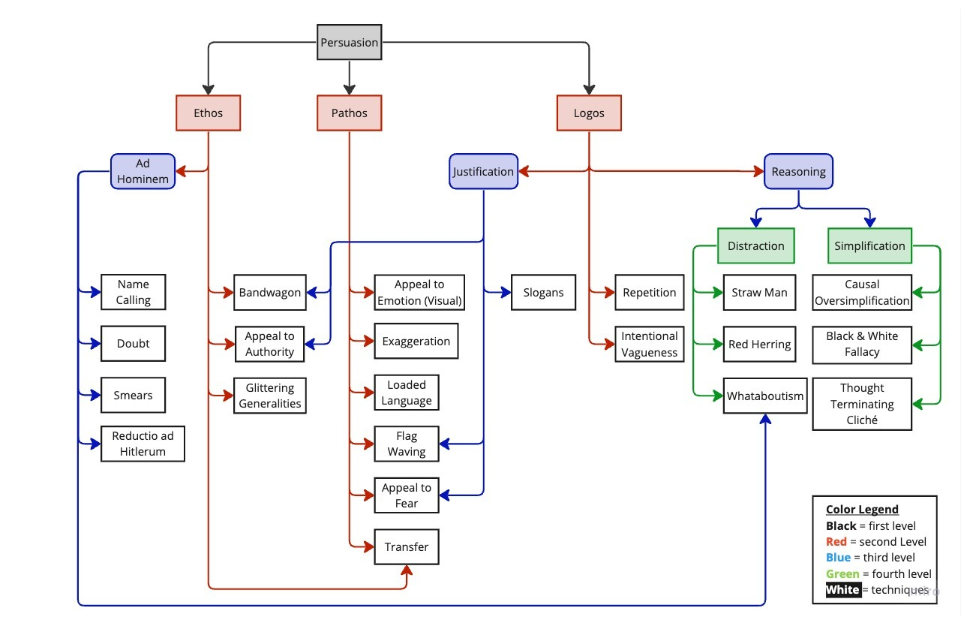

In [10]:
graph = {
    'Persuasion': ['Ethos', 'Pathos', 'Logos'],
    'Ethos': ['Ad Hominem', 'Bandwagon', 'Appeal to authority', 'Glittering generalities (Virtue)'], 
    'Pathos': ['Exaggeration/Minimisation', 'Loaded Language', 'Flag-waving', 'Appeal to fear/prejudice'], 
    'Logos': ['Justification', 'Reasoning', 'Repetition', 'Obfuscation, Intentional vagueness, Confusion'],
    'Ad Hominem': ['Name calling/Labeling', 'Doubt', 'Smears', 'Reductio ad hitlerum', 'Whataboutism'],
    'Justification': ['Bandwagon', 'Appeal to authority', 'Flag-waving', 'Appeal to fear/prejudice', 'Slogans'],
    'Reasoning': ['Distraction', 'Simplification'],
    'Distraction': ["Misrepresentation of Someone's Position (Straw Man)", 'Presenting Irrelevant Data (Red Herring)', 'Whataboutism'], 
    'Simplification': ['Causal Oversimplification', 'Black-and-white Fallacy/Dictatorship', 'Thought-terminating cliché']
}



replace = {n: i for i, n in enumerate(set(graph.keys()) | labels_set)}
replace_back = {i: n for i, n in enumerate(set(graph.keys()) | labels_set)}
ancestors = {replace['Persuasion']: set([replace['Persuasion']])}

for a, lst in graph.items():
    a_ = replace[a]
    for b in lst:
        b_ = replace[b]
        ancestors[b_] = ancestors.get(b_, set()) | set([b_]) | ancestors[a_]

In [11]:
leafs = set(replace.keys()) - set(graph.keys())
len(leafs)

20

In [12]:
leaf_mask = torch.zeros((len(replace),), dtype=torch.float32)
leaf_mask[[replace[n] for n in leafs]] = 1.0
leaf_mask

tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.])

In [13]:
ancestors_matrix = torch.zeros((len(ancestors), len(ancestors)), dtype=torch.float32)
for a, lst in ancestors.items():
    ancestors_matrix[a, list(lst)] = 1.0

In [14]:
x = torch.zeros((1, len(ancestors),), dtype=torch.float32)
x[0, 16] = 1
x[0, 12] = 1
torch.where(x @ ancestors_matrix > 0)

(tensor([0, 0, 0, 0, 0]), tensor([ 7, 12, 16, 20, 27]))

In [15]:
classes = len(replace)

In [16]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, replace, replace_back):
        self.df = df
        self.labels = df['labels']
        for idx in df.index:
            ls = self.labels.iloc[idx]
            ls_new = set()
            for n in ls:
                ls_new |= ancestors[replace[n]]
            ls_new = [replace_back[n] for n in ls_new]
            self.labels.iloc[idx] = ls_new
        self.texts = df['text']
        self.replace = replace
        self.replace_back = replace_back
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        y = [self.replace[n] for n in self.labels.iloc[idx]]
        labels = torch.zeros(len(self.replace))
        labels[y] = 1
#         weights = torch.zeros(len(self.replace), dtype=torch.float32)
#         weights[y] = 1
#         for n in self.labels.iloc[idx]:
#             for m in graph.get(n, []):
#                 weights[self.replace[m]] = 1
        return labels, leaf_mask

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        text = self.texts.iloc[idx]
        tokens = self.tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
        tokens = [w for w, _ in tokens]
        return tokens
#         return tokenizer(text,
#                         padding='max_length', max_length = 512, truncation=True,
#                         return_tensors="pt")

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y, weights = self.get_batch_labels(idx)

        return batch_texts, batch_y, weights

In [17]:
class TransformersCollator:
    def __init__(self, tokenizer, tokenizer_kwargs, label_padding_value):
        self.tokenizer = tokenizer
        self.tokenizer_kwargs = tokenizer_kwargs
        self.label_padding_value = label_padding_value

    def __call__(self, batch):
        tokens, labels, w = zip(*batch)

        tokens = self.tokenizer(tokens, **self.tokenizer_kwargs)

        tokens.pop("offset_mapping")
        
        return tokens, torch.stack(labels), torch.stack(w)

# Model

In [18]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [19]:
class TransformerModel(nn.Module):

    def __init__(self):

        super(TransformerModel, self).__init__()

        self.bert = AutoModel.from_pretrained(CFG.model_name)

        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        self.dropout4 = nn.Dropout(0.4)
        self.dropout5 = nn.Dropout(0.5)
        self.pool = MeanPooling()
        self.clf =  nn.Linear(CFG.dim, classes)

        torch.nn.init.xavier_uniform_(self.clf.weight)
#         for param in self.bert.parameters():
#             param.requires_grad = False

    def forward(self, x):
        input_id = x['input_ids'].squeeze(1)
        mask = x['attention_mask']
        # sequence has [CLF] token in the beginning
        # bert() returns first vector as pooling of sentence
#         _, x = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
        x = self.bert(input_ids= input_id, attention_mask=mask)[0]
        x = self.pool(x, mask)
        x1 = self.dropout1(x)
        x2 = self.dropout2(x)
        x3 = self.dropout3(x)
        x4 = self.dropout4(x)
        x5 = self.dropout5(x)
        x = (x1 + x2 + x3 + x4 + x5) / 5
        out = self.clf(x)
        return out

# TRAIN

In [20]:
def get_prediction(y):
#     l0 = [replace['Persuasion']]
#     l1 = [replace['Ethos'], replace['Pathos'], replace['Logos']]
#     l2 = [replace['Ad Hominem'], replace['Justification'], replace['Reasoning']]
#     l3 = [replace['Distraction'], replace['Simplification']]
    
#     y[l0[0]] = (y[l0[0]] > 0).to(torch.float32)
    
#     y[l1[0]] = y[l0[0]] * (y[l1[0]] > 0).to(torch.float32)
#     y[l1[1]] = y[l0[0]] * (y[l1[1]] > 0).to(torch.float32)
#     y[l1[2]] = y[l0[0]] * (y[l1[2]] > 0).to(torch.float32)
    
#     y[l2[0]] = y[l1[0]] * (y[l2[0]] > 0).to(torch.float32)
#     y[l2[1]] = y[l1[2]] * (y[l2[1]] > 0).to(torch.float32)
#     y[l2[2]] = y[l1[2]] * (y[l2[2]] > 0).to(torch.float32)
    
#     y[l3[0]] = y[l2[2]] * (y[l3[0]] > 0).to(torch.float32)
#     y[l3[1]] = y[l2[2]] * (y[l3[1]] > 0).to(torch.float32)
    
#     for i, lst in graph.items():
#         i = replace[i]
#         for j in lst:
#             j = replace[j]
#             y[j] = y[i] * (y[j] > 0).to(torch.float32)
            
        
    return (y > 0).to(torch.float32)

In [21]:
y = torch.zeros(len(replace), dtype=torch.float32)
y[9] = 1.0
y[2] = 1.0
y, y @ ancestors_matrix

(tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0.]))

In [22]:
[replace_back[i] for i in np.where(y @ ancestors_matrix > 0)[0]]

['Repetition', 'Justification', 'Slogans', 'Persuasion', 'Logos']

In [23]:
def f_score(y_pred, y_true):
    y_true_anc =  torch.clip(y_true @ ancestors_matrix, 0, 1)
    y_pred = get_prediction(y_pred)
    y_pred_anc = torch.clip(y_pred @ ancestors_matrix, 0, 1)
    
    
    tp = (y_true_anc * y_pred_anc).sum()
    hr = tp / y_true_anc.sum()
    hp = tp / y_pred_anc.sum()
    f1 = 2.0 * hr * hp / (hr + hp)
    return {'F1': f1, 'hR': hr, 'hP': hp}

In [24]:
def calc_metrics(y_hat, y, metrics_func=[]):
    metrics = {}
    for f in metrics_func:
        metrics.update(f(y_hat, y))
    return metrics

In [25]:
class wBCE(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    
    def forward(self, y_hat, y, w):
        return self.bce(y_hat, y).mean()
#         loss = self.bce(y_hat, y) * w
#         loss = loss.sum() / w.sum()
#         return loss

In [26]:
class LitModel(pl.LightningModule):

    def __init__(self, model, loss, optimizer, scheduler, metric_functions):
        super().__init__()
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_functions = metric_functions
        self.train_y_out = []
        self.train_y = []
        self.val_y_out = []
        self.val_y = []
        self.history = []

    def calc_grad_norm(self):
        total_norm = 0
        parameters = [p for p in self.model.parameters() if p.grad is not None and p.requires_grad]
        for p in parameters:
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        return total_norm
    
    def _common_step(self, batch, batch_idx):
        (x, y, w) = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y, w)
        return {
            'loss': loss,
            'y': y_hat
        }

    def training_step(self, batch, batch_idx):
        res = self._common_step(batch, batch_idx)
        loss = res['loss']
        # self.train_y_out.append(res['y'])
        # self.train_y.append(batch[1])
        self.log_dict(
            {'loss/Train': loss.detach().cpu().item()},
            on_step=True,
            on_epoch=False,
            prog_bar=True,
        )
        self.logger.log_metrics(
            {
                'loss/Train': loss.detach().cpu().item(), 
                'grad_norm': self.calc_grad_norm(),
                'lr': self.optimizer.param_groups[0]['lr']
            }, 
            self.global_step)
        return res

    def on_training_epoch_end(self):
        y_hat = torch.cat(self.train_y_out, dim=0)
        y = torch.cat(self.train_y, dim=0)
        
        metrics = calc_metrics(y_hat.detach().cpu(), y.detach().cpu(), self.metric_functions)
        self.log_dict(
            {n+'/Train': v for n, v in metrics.items()},
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        
        for name, val in metrics.items():
            self.logger.log_metrics({name + '/Train': val}, self.global_step)

        self.train_y_out.clear()
        self.train_y.clear()

    def validation_step(self, batch, batch_idx):
        res = self._common_step(batch, batch_idx)
        loss = res['loss']
        self.val_y_out.append(res['y'])
        self.val_y.append(batch[1])
        return res

    def on_validation_epoch_end(self):
        y_hat = torch.cat(self.val_y_out, dim=0)
        y = torch.cat(self.val_y, dim=0)

        metrics = calc_metrics(y_hat.detach().cpu(), y.detach().cpu(), self.metric_functions)
        self.log_dict(
            {n+'/Valid': v for n, v in metrics.items()},
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.history += [metrics.copy()]
        for name, val in metrics.items():
            self.logger.log_metrics({name + '/Valid': val}, self.global_step)

        self.val_y_out.clear()
        self.val_y.clear()
      
    def test_step(self, *args, **kwargs):
        self.validation_step(*args, **kwargs)
    
    def on_test_epoch_end(self):
        y_hat = torch.cat(self.val_y_out, dim=0)
        y = torch.cat(self.val_y, dim=0)

        metrics = calc_metrics(y_hat.detach().cpu(), y.detach().cpu(), self.metric_functions)
        self.log_dict(
            {n+'/Test': v for n, v in metrics.items()},
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        for name, val in metrics.items():
            self.logger.log_metrics({name + '/Test': val}, self.global_step)

        self.val_y_out.clear()
        self.val_y.clear()

    def configure_optimizers(self):
        if self.scheduler is None:
            return [self.optimizer], []
        return [self.optimizer], [self.scheduler]

In [27]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)
model = TransformerModel()
loss = wBCE()
optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = {
          'scheduler': get_linear_schedule_with_warmup(optimizer, num_warmup_steps=CFG.num_warmup_steps, num_training_steps=CFG.num_training_steps),
          'interval': 'step',
          'frequency': 1,
        }
# get_linear_schedule_with_warmup(optimizer, num_warmup_steps=CFG.num_warmup_steps, num_training_steps=CFG.num_training_steps)
#  get_cosine_schedule_with_warmup

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
checkpoint_callback = ModelCheckpoint(
    mode="max",
    filename=CFG.model_path,
    dirpath=CFG.checkpoint_dir,
    save_top_k=1, monitor="F1/Valid"
    )
logger = TensorBoardLogger(
    save_dir=CFG.log_dir,
    name=CFG.exp_name,
    )

In [29]:
tokenizer_kwargs = {
    "is_split_into_words":    True,
    "return_offsets_mapping": True,
    "padding":                'max_length',
    "truncation":             True,
    "max_length":             CFG.max_len,
    "return_tensors":         "pt",
}
collator = TransformersCollator(
    tokenizer=tokenizer,
    tokenizer_kwargs=tokenizer_kwargs,
    label_padding_value=-1,
)

In [30]:
train_ds = Dataset(train_df, tokenizer, replace, replace_back)
valid_ds = Dataset(valid_df, tokenizer, replace, replace_back)

In [31]:
train_batch_size = CFG.batch_size
test_batch_size = CFG.batch_size
train_dataloader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    drop_last=False,
    collate_fn=collator,
    num_workers=1
)
val_dataloader = DataLoader(
    valid_ds,
    batch_size=test_batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collator,
    num_workers=1
)

In [32]:
trainer = pl.Trainer(
    logger=logger,
    max_epochs=CFG.epochs,
    devices=CFG.n_dev, accelerator=CFG.dev,
    callbacks=[checkpoint_callback],
    val_check_interval=CFG.validate_every_n,
    # precision=16,
#     amp_backend="apex",
    num_sanity_val_steps=0
    )

clf_model = LitModel(model, loss, optimizer, scheduler, metric_functions=[f_score])

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [33]:
# clf_model.load_state_dict(torch.load('/kaggle/input/semeval2024subtask1/bert_lr2e-05_bs8.ckpt')['state_dict'])

In [34]:
trainer.fit(
    clf_model,
    train_dataloader,
    val_dataloader
    )

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.


In [35]:
clf_model.history

[{'F1': tensor(0.5343), 'hR': tensor(0.4483), 'hP': tensor(0.6610)},
 {'F1': tensor(0.5568), 'hR': tensor(0.4393), 'hP': tensor(0.7602)},
 {'F1': tensor(0.5814), 'hR': tensor(0.4816), 'hP': tensor(0.7332)},
 {'F1': tensor(0.5978), 'hR': tensor(0.5019), 'hP': tensor(0.7391)},
 {'F1': tensor(0.6440), 'hR': tensor(0.5959), 'hP': tensor(0.7006)},
 {'F1': tensor(0.6196), 'hR': tensor(0.5273), 'hP': tensor(0.7509)},
 {'F1': tensor(0.6652), 'hR': tensor(0.6599), 'hP': tensor(0.6705)},
 {'F1': tensor(0.6561), 'hR': tensor(0.6097), 'hP': tensor(0.7100)},
 {'F1': tensor(0.6562), 'hR': tensor(0.6049), 'hP': tensor(0.7171)},
 {'F1': tensor(0.6386), 'hR': tensor(0.5431), 'hP': tensor(0.7750)},
 {'F1': tensor(0.6499), 'hR': tensor(0.5996), 'hP': tensor(0.7093)},
 {'F1': tensor(0.6424), 'hR': tensor(0.5509), 'hP': tensor(0.7702)},
 {'F1': tensor(0.6680), 'hR': tensor(0.6401), 'hP': tensor(0.6984)},
 {'F1': tensor(0.6793), 'hR': tensor(0.6573), 'hP': tensor(0.7028)},
 {'F1': tensor(0.6675), 'hR': tens

In [36]:
with open('/kaggle/input/semeval2024subtask1/dev_gold_labels/dev_gold_labels/dev_subtask1_en.json') as fp:
    dev = json.load(fp)

In [37]:
dev_df = pd.DataFrame(dev)

In [38]:
# dev_df['labels'] = [[]] * len(dev_df) 

In [39]:
dev_ds = Dataset(dev_df, tokenizer, replace, replace_back)

In [40]:
dev_dataloader = DataLoader(
    dev_ds,
    batch_size=test_batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collator,
    num_workers=1
)

In [41]:
trainer.test(clf_model, dataloaders=[dev_dataloader])

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          F1/Test          │    0.6794664859771729     │
│          hP/Test          │    0.6532179117202759     │
│          hR/Test          │    0.7079129219055176     │
└───────────────────────────┴───────────────────────────┘

[{'F1/Test': 0.6794664859771729,
  'hR/Test': 0.7079129219055176,
  'hP/Test': 0.6532179117202759}]

In [42]:
with open('/kaggle/input/semeval2024subtask1/subtask1/dev_unlabeled.json') as fp:
    dev = json.load(fp)
dev_df = pd.DataFrame(dev)
dev_df['labels'] = [[]] * len(dev_df) 
dev_ds = Dataset(dev_df, tokenizer, replace, replace_back)
dev_dataloader = DataLoader(
    dev_ds,
    batch_size=test_batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collator,
    num_workers=1
)

In [43]:
from tqdm import tqdm

In [44]:
final_model = clf_model.model
final_model.eval()
clf_model.to(CFG.device)
res = []
with torch.no_grad():
    for x, y, w in tqdm(dev_dataloader):
        x = x.to(CFG.device)
        res += [final_model(x)]

100%|██████████| 125/125 [00:25<00:00,  4.86it/s]


In [45]:
res = torch.cat(res, dim=0)

In [46]:
res = get_prediction(res)

In [47]:
res.size()

torch.Size([1000, 29])

In [48]:
[replace_back[j.item()] for j in torch.where(res[2]>0.5)[0]]

['Smears',
 'Pathos',
 'Simplification',
 'Reasoning',
 'Ethos',
 'Doubt',
 'Persuasion',
 'Causal Oversimplification',
 'Ad Hominem',
 'Logos']

In [49]:
res.size(), dev_df.shape

(torch.Size([1000, 29]), (1000, 3))

In [50]:
for i in dev_df.index:
    dev_df.loc[i, 'labels'].extend([replace_back[j.item()] for j in torch.where(res[i]>0.5)[0] if replace_back[j.item()] != 'Persuasion'])

In [51]:
dev_df

,id,text,labels
0,63292,This is why we're free\n\nThis is why we're sa...,"[Repetition, Black-and-white Fallacy/Dictators..."
1,70419,IF YOU SAY WE'RE IN THE MIDDLE OF A DEADLY PAN...,"[Black-and-white Fallacy/Dictatorship, Simplif..."
2,63673,AFTER A YEAR OF ZERO EVIDENCE OF RUSSIAN COLLU...,"[Smears, Pathos, Simplification, Reasoning, Et..."
3,71297,MY WAY MY WAY,[]
4,66340,Putin signed a decree to exclude Lyman from Ru...,"[Loaded Language, Smears, Pathos, Ethos, Ad Ho..."
...,...,...,...
995,70426,CATHING MEXICANS!!!,"[Ethos, Name calling/Labeling, Ad Hominem]"
996,64176,\I WILL NEVER REGRET MY SUPPORT FOR PRESIDENT ...,"[Justification, Appeal to authority, Ethos, Lo..."
997,68485,DEMAND KING SALMAN RELEASE CLERIC SHEIKH SALMA...,"[Black-and-white Fallacy/Dictatorship, Simplif..."
998,75006,"\LISTEN TO MY ORDERS, EVIL PUPPET...\n\n... I ...","[Loaded Language, Pathos, Justification, Black..."


In [52]:
dev_df = dev_df.drop(columns=['text'])
dev_df.head()

,id,labels
0,63292,"[Repetition, Black-and-white Fallacy/Dictators..."
1,70419,"[Black-and-white Fallacy/Dictatorship, Simplif..."
2,63673,"[Smears, Pathos, Simplification, Reasoning, Et..."
3,71297,[]
4,66340,"[Loaded Language, Smears, Pathos, Ethos, Ad Ho..."


In [53]:
with open('sub_task1.json', 'w') as fp:
    json.dump([dev_df.iloc[i].to_dict() for i in range(len(dev_df))], fp)